# Titanic Survival Prediction

### In this notebook, the main goal is to build a binary classifier to predict whether a person on the Titanic could survive given his or her information. I have my plans written below:

1. Explore the data to remove non-numerical data to create a simplified dataframe and build a model prototype.
2. Plot the learning curve to determine promising moves to improve the performance of our model.
3. feature analysis and feature engineering 
4. Fit the several models using the augmented dataframe. For this problem, I will use the following models: RandomForestClassifier, XGBoost.
5. Fine tuning the hyperparameters.
6. Compare the scores of different learning model and select the best one.

In [24]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

In [25]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I will first build an over-simplified prototype model and plot the learning curve to see from which perspective I can improve the model performance.

In [26]:
full_set = [df_train, df_test]

# drop the non-numeric value columbs
df_sim = df_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df_sim['Sex'] = df_sim.Sex.apply(lambda x: 1 if x == 'male' else 0)

# examine the null values and make sure all entries are numerical type
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [27]:
# replace null values in age by the mean
mean_age = np.mean(df_sim.Age)
df_sim.loc[df_sim.Age.isnull(), 'Age'] = mean_age
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [28]:
# create x and y values for training purposes
x = df_sim.drop('Survived', axis=1)
y = df_sim['Survived']

# train the model using random forest method
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
sim_cv_result = cross_validate(rf_clf, x, y, scoring=('f1','accuracy'), cv=3)
print('F1-Score: {}. Accuracy:{}'.format(np.mean(sim_cv_result['test_f1']), np.mean(sim_cv_result['test_accuracy'])))

F1-Score: 0.7375295669101795. Accuracy:0.8125701459034792


After building the random forest model using a simplified data set, we can see from the F1-score that there is plenty of room for improvement. The key is to find the promising steps to better our models and devote more time in the step that could possibly significantly improve the performance. Thus, we need to plot the learning curve to decide our next step.

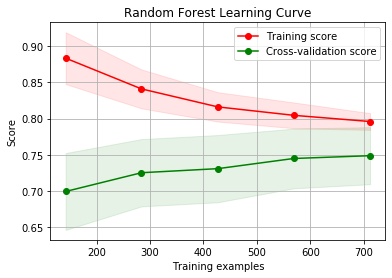

In [14]:
# This function is taken from sklearn official documentation and modified a little

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.2, 1.0, 5), scoring=None):
    
    'plot the learning curve given the data and specified estimator'

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = 'Random Forest Learning Curve'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=5)
plot_learning_curve(estimator=clf, title=title, X=x, y=y, cv=cv, n_jobs=-1, scoring='f1')
plt.show()

From the curve we can tell from the trend that the bias and variance are not optimal. To reduce bias and variance, the possible solutions are:
(1) get more data 
(2) create more features and utilize regularizer

While getting more training data is unlikely, it seems promising to do feature engineering on the original data set.

In [29]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [30]:
full_set = [df_train, df_test]

def cabin_class(row):
    'map cabin to a categorical number'
    cabin_to_num = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
    if row['Cabin'] is np.NaN or row['Cabin'][0] not in cabin_to_num:
        return 8
    
    return cabin_to_num[row['Cabin'][0]]

def embark(row):
    'map embark port to categorical number'
    embark_to_num = {'S':1, 'C':2, 'Q':3}
    if row.Embarked not in embark_to_num:
        return 0
    return embark_to_num[row.Embarked]

for dataset in full_set:
    # create new feature cabin_category to indicate which class of cabin the passenger is in
    dataset['cabin_category'] = dataset.apply(cabin_class, axis=1)
    
    # create new feature embark to indicate from which location the passenger boards Titanic
    dataset['embark'] = dataset.apply(embark, axis=1)
    
    # create new feature family_size to indicate the passenger is travelling with how many family members
    dataset['family_size'] = dataset.SibSp + dataset.Parch + 1
    
    # create new feature is_alone to indicate whether the passenger is traveling alone
    dataset['is_alone'] = dataset.family_size.apply(lambda x: 1 if x == 1 else 0)
    
    # map sex from string to int
    dataset['gender'] = dataset.apply(lambda x: 1 if x.Sex == 'male' else 0, axis=1)
    
    # replace the missing values in age by average
    mean_age = np.mean(dataset[dataset.Age.notnull()].Age)
    dataset.loc[dataset.Age.isnull(), 'Age'] = mean_age
    
    
# drop the duplicate or less useful columns like Name and create y dataframe
y_train = df_train.Survived
x_train = df_train.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Survived', 'SibSp'], axis=1)

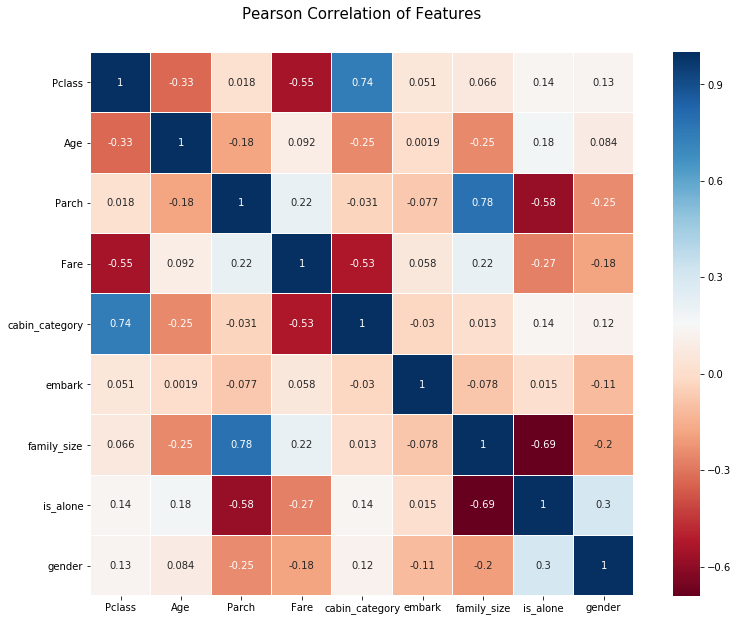

In [8]:
# plot Pearson Correlation Heatmap to check the correlation between features
colormap = plt.cm.RdBu
plt.figure(figsize=(14,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(x_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

From the heatmap, we notice that the correlation between Parch and family_size is a bit concerning, but the value is smaller than 0.8 and we will proceed with the current features.


In [9]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
cv_result = cross_validate(rf_clf, x_train, y_train, scoring=('f1','accuracy'), cv=3)
print('F1-Score: {}. Accuracy:{}'.format(np.mean(cv_result['test_f1']), np.mean(cv_result['test_accuracy'])))

F1-Score: 0.7388018112156044. Accuracy:0.8148148148148149


we can see that the F1-score and Accuracy improve a little compared to the prototype model.
now we will try other classifiers, e.g. the famous XGBoostClassifier to see the model improvement.
The advantage of XGBoost is that it is able to handle null values, also, it is able to add a regularization factor to reduce variance.
Thus, I am going to modify the dataset accordingly.

In [10]:
def modify_dataset(dataset):

    # create new feature cabin_category to indicate which class of cabin the passenger is in
    dataset['cabin_category'] = dataset.apply(cabin_class, axis=1)

    # create new feature embark to indicate from which location the passenger boards Titanic
    dataset['embark'] = dataset.apply(embark, axis=1)

    # create new feature family_size to indicate the passenger is travelling with how many family members
    dataset['family_size'] = dataset.SibSp + dataset.Parch + 1

    # create new feature is_alone to indicate whether the passenger is traveling alone
    dataset['is_alone'] = dataset.family_size.apply(lambda x: 1 if x == 1 else 0)

    # map sex from string to int
    dataset['gender'] = dataset.apply(lambda x: 1 if x.Sex == 'male' else 0, axis=1)
    
    dataset_ = dataset.drop(['PassengerId', 'Sex', 'Name', 'Ticket', 'Embarked', 'Cabin', 'SibSp'], axis=1)
    return dataset_

dataset = pd.read_csv('data/train.csv')
x_train_xgb = modify_dataset(dataset).drop('Survived', axis=1)
x_train_xgb.head()

,Pclass,Age,Parch,Fare,cabin_category,embark,family_size,is_alone,gender
0,3,22.0,0,7.2500,8,1,2,0,1
1,1,38.0,0,71.2833,3,2,2,0,0
2,3,26.0,0,7.9250,8,1,1,1,0
3,1,35.0,0,53.1000,3,1,2,0,0
4,3,35.0,0,8.0500,8,1,1,1,1


In [11]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=5)
xgb_score = cross_validate(xgb_clf, x_train_xgb, y_train, cv=3, scoring=('f1', 'accuracy'))
print('F1-Score: {}. Accuracy:{}'.format(np.mean(xgb_score['test_f1']), np.mean(xgb_score['test_accuracy'])))

F1-Score: 0.7536556039350156. Accuracy:0.8260381593714926


In [12]:
title = 'XGBoost Learning Curve'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=1)
xgb_clf = XGBClassifier(n_estimators=100, max_depth=5)
plot_learning_curve(estimator=clf, title=title, X=x_train_xgb, y=y_train, cv=cv, n_jobs=-1, scoring='f1')
plt.show()

NameError: name 'plot_learning_curve' is not defined

In [13]:
# From the learning curve we know the model still has relatively high variance
# I will use grid search to tune the parameters manually to improve the model performance
xgb_clf.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)>

In [14]:
# construct a class for grid search cross validation to avoid repeated code
class GridSearchHelper(object):
    def __init__(self, clf, clf_params, param_grid, seed, x, y):
        clf_params['random_state'] = seed
        self.clf_base = clf(**clf_params)
        self.param_grid = param_grid
        self.x = x
        self.y = y
        
    def fit(self):
        grid_clf = GridSearchCV(self.clf_base, self.param_grid, cv=3)
        grid_clf.fit(self.x, self.y)
        return grid_clf
    
    def get_result(self):
        clf = self.fit()
        result = pd.DataFrame(clf.cv_results_).sort_values(['mean_test_score', 'std_test_score'], \
                                                           ascending=[False, True])
        return result

In [15]:
# The first step of tuning will be finding optimal n_estimators
#xgb_clf = xgb.XGBClassifier(max_depth=5, random_state=0)
param_grid = {'n_estimators':(100, 80, 70, 60, 50, 40)}
param = {'max_depth':5}
estimator_gs = GridSearchHelper(clf=XGBClassifier, clf_params=param, param_grid=param_grid, seed=0, x=x_train_xgb, y=y)
estimator_gs.get_result()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,0.021252,0.000042,0.001460,0.000086,40,{'n_estimators': 40},0.797980,0.855219,0.824916,0.826038,0.023381,1
0,0.052052,0.005061,0.001952,0.000184,100,{'n_estimators': 100},0.791246,0.845118,0.841751,0.826038,0.024640,1
3,0.027709,0.000198,0.001220,0.000013,60,{'n_estimators': 60},0.787879,0.851852,0.838384,0.826038,0.027537,1
4,0.023515,0.000187,0.001165,0.000022,50,{'n_estimators': 50},0.787879,0.855219,0.828283,0.823793,0.027674,4
2,0.031743,0.000135,0.001336,0.000021,70,{'n_estimators': 70},0.784512,0.845118,0.835017,0.821549,0.026512,5
1,0.037594,0.000243,0.001491,0.000046,80,{'n_estimators': 80},0.784512,0.841751,0.835017,0.820426,0.025544,6


In [16]:
# Although there are multiple rank 1 values, we choose n_estimators=40 for its lowest std.
# tune max_depth and min_child_weight
param_grid = {'min_child_weight':np.arange(1,6), 'max_depth':np.arange(0,6,1)}
param = {'n_estimators':40}
estimator_gs = GridSearchHelper(clf=XGBClassifier, clf_params=param, param_grid=param_grid, seed=0, x=x_train_xgb, y=y)
estimator_gs.get_result().head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
27,0.020430,0.000166,0.001292,0.000040,5,3,"{'max_depth': 5, 'min_child_weight': 3}",0.808081,0.858586,0.835017,0.833895,0.020634,1
22,0.016651,0.000188,0.000999,0.000011,4,3,"{'max_depth': 4, 'min_child_weight': 3}",0.804714,0.851852,0.831650,0.829405,0.019309,2
28,0.020057,0.000454,0.001303,0.000028,5,4,"{'max_depth': 5, 'min_child_weight': 4}",0.808081,0.841751,0.835017,0.828283,0.014547,3
26,0.020431,0.000140,0.001310,0.000069,5,2,"{'max_depth': 5, 'min_child_weight': 2}",0.811448,0.841751,0.828283,0.827160,0.012397,4
25,0.021505,0.001043,0.001428,0.000147,5,1,"{'max_depth': 5, 'min_child_weight': 1}",0.797980,0.855219,0.824916,0.826038,0.023381,5


In [17]:
# store the optimal value for max_depth, and min_child_weight
param = {'n_estimators':40, 'max_depth':5, 'min_child_weight':3}
# tune gamma
param_grid = {'gamma':np.arange(0,11)/10}
estimator_gs = GridSearchHelper(clf=XGBClassifier, clf_params=param, param_grid=param_grid, seed=0, x=x_train_xgb, y=y)
estimator_gs.get_result().head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021411,0.000304,0.001422,0.000190,0,{'gamma': 0.0},0.808081,0.858586,0.835017,0.833895,0.020634,1
1,0.020557,0.000351,0.001203,0.000031,0.1,{'gamma': 0.1},0.808081,0.855219,0.835017,0.832772,0.019309,2
2,0.019759,0.000286,0.001059,0.000019,0.2,{'gamma': 0.2},0.801347,0.855219,0.841751,0.832772,0.022891,2
6,0.019958,0.000170,0.001078,0.000006,0.6,{'gamma': 0.6},0.804714,0.851852,0.838384,0.831650,0.019824,4
3,0.020433,0.000772,0.001282,0.000151,0.3,{'gamma': 0.3},0.794613,0.861953,0.838384,0.831650,0.027901,4


In [18]:
# store the optimal value for max_depth, and min_child_weight
param = {'n_estimators':40, 'max_depth':5, 'min_child_weight':3, 'gamma':0}
# tune subsample
param_grid = {'subsample':np.arange(5,11)/10}
estimator_gs = GridSearchHelper(clf=XGBClassifier, clf_params=param, param_grid=param_grid, seed=0, x=x_train_xgb, y=y)
estimator_gs.get_result().head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,0.019931,0.000188,0.001095,0.000030,1,{'subsample': 1.0},0.808081,0.858586,0.835017,0.833895,0.020634,1
2,0.020982,0.000063,0.001157,0.000007,0.7,{'subsample': 0.7},0.797980,0.845118,0.838384,0.827160,0.020816,2
4,0.020663,0.000191,0.001241,0.000096,0.9,{'subsample': 0.9},0.791246,0.858586,0.831650,0.827160,0.027674,2
3,0.020951,0.000133,0.001281,0.000092,0.8,{'subsample': 0.8},0.787879,0.855219,0.838384,0.827160,0.028614,2
1,0.021418,0.000225,0.001339,0.000020,0.6,{'subsample': 0.6},0.787879,0.861953,0.831650,0.827160,0.030407,2


In [19]:
# store the optimal value for subsample
param['subsample'] = 1
# Turning regularization factor 
#param_grid = {'reg_alpha':np.arange(0,1.1,0.2), 'reg_lambda':np.arange(0,1.1,0.2)}
param_grid = {'reg_alpha':(0,1), 'reg_lambda':(0,1)}
estimator_gs = GridSearchHelper(clf=XGBClassifier, clf_params=param, param_grid=param_grid, seed=0, x=x_train_xgb, y=y)
estimator_gs.get_result().head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.019913,0.000191,0.001082,0.000013,0,1,"{'reg_alpha': 0, 'reg_lambda': 1}",0.808081,0.858586,0.835017,0.833895,0.020634,1
0,0.024554,0.001675,0.001500,0.000150,0,0,"{'reg_alpha': 0, 'reg_lambda': 0}",0.797980,0.858586,0.845118,0.833895,0.025984,1
2,0.019779,0.000468,0.001134,0.000081,1,0,"{'reg_alpha': 1, 'reg_lambda': 0}",0.808081,0.851852,0.835017,0.831650,0.018027,3
3,0.019007,0.000243,0.001014,0.000011,1,1,"{'reg_alpha': 1, 'reg_lambda': 1}",0.814815,0.841751,0.831650,0.829405,0.011111,4


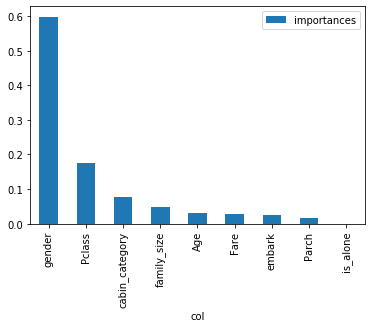

In [23]:
# store reg_alpha and reg_lambda and fit model to predict value in test set
param.update({'reg_alpha':0, 'reg_lambda':1})
xgb_best = estimator_gs.fit().best_estimator_
# check the feature importance to get some insight
feature_importance = xgb_best.feature_importances_
feature_df = pd.DataFrame({'col':x_train_xgb.columns, 'importances':feature_importance})
feature_df = feature_df.sort_values('importances', ascending=False)
feature_df.plot(kind='bar', x='col', y='importances')



In [21]:
x_train_xgb.columns

Index(['Pclass', 'Age', 'Parch', 'Fare', 'cabin_category', 'embark',
       'family_size', 'is_alone', 'gender'],
      dtype='object')

In [22]:
# prepare test set
dataset = pd.read_csv('data/test.csv')
df_test = modify_dataset(dataset)
xgb_best.fit(x_train_xgb, y)
test_survival = xgb_best.predict(df_test)
submission_csv = pd.DataFrame({'PassengerId': dataset.PassengerId, 'Survived':test_survival})
submission_csv.to_csv('submission.csv', index=False)